In [2]:
import torch
import json
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
# LOAD FINE-TUNED MODEL FROM DISK

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = torch.load('./torch-cache/test2.ckpt', map_location=torch.device('cpu'))
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

with open('./torch-cache/authors.json') as file:
    authors = json.load(file)
    print(f"Authors list: {authors}")

c:\Users\kauhe\anaconda3\envs\authorship-problem\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\kauhe\AppData\Local\Temp\ipykernel_14528\1684595006.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_global

Total number of parameters: 109489161
Authors list: ['dekker', 'fletcher', 'ford', 'jonson', 'massinger', 'middleton', 'rowley', 'shakespeare', 'webster']


In [4]:
# PORT OF PREPROCESSING SCRIPT USED ON CORPUS

import re
from typing import List

def process_line(line: str) -> str:
    result = line

    # Remove stuff between brackets
    bracket_processed = False
    if '[' in line and ']' in line:
        fst_bracket_idx = line.index('[')
        snd_bracket_idx = line.index(']')
        if fst_bracket_idx < snd_bracket_idx:
            result = result[:fst_bracket_idx] + result[snd_bracket_idx + 1:]
            bracket_processed = True
    if not bracket_processed and '[' in line:
        fst_bracket_idx = line.index('[')
        result = result[:fst_bracket_idx]
        bracket_processed = True
    if not bracket_processed and ']' in line:
        snd_bracket_idx = line.index(']')
        result = result[snd_bracket_idx + 1:]
        bracket_processed = True

    # Remove symbols and ALL CAPS words, and normalize punctuation
    result = re.sub(r"[’‘]", "'", result)
    result = re.sub(r"[_,:;\[\]\{\}\(\)—“”&<>$/\\=+\`^]", '', result)
    result = re.sub(r"[0-9]", '', result)
    result = result.replace('-', ' ')
    result = re.sub(r"[\?\!]", '.', result)

    words = result.split(' ')
    words = [word for word in words if not (word.isupper() and len(word) > 1)]
    result = ' '.join(words)

    return result

def process_text(text: str) -> List[str]:
    # Remove excess white space and process each line
    lines = text.split('\n')
    lines = [line.strip() for line in lines]
    lines = [process_line(line) for line in lines]
    lines = [line for line in lines if line]
    result = ' '.join(lines)

    # Clean up sentences
    sentences = result.split('.')
    sentences = [sentence.strip().lower() for sentence in sentences]
    sentences = [sentence.split(' ') for sentence in sentences]
    sentences = [[token for token in tokens if token] for tokens in sentences]
    sentences = [
        [word for word in tokens if not (len(word) == 1 and word in [
            'b', 'c', 'f', 'g', 'h', 'j', 'k',
            'p', 'q', 'r', 'v', 'w', 'x', 'y', 'z'
        ])]
        for tokens in sentences
    ]
    sentences = [' '.join(tokens) for tokens in sentences if len(tokens) > 2]

    return sentences

In [5]:
# FORMAT INFERENCE INPUT (RAW COPY PASTE) INTO BERT INPUT and MASK

sentence = """
_Frank._                      So you promised me
Before, in case I married her. I know
Sir Arthur Clarington deserves the credit
Report hath lent him, and presume you are
A debtor to your promise: but upon
What certainty shall I resolve? Excuse me
For being somewhat rude.

_Sir Arth._              It is but reason.
Well, Frank, what think'st thou of two hundred pounds
And a continual friend?

_Frank._               Though my poor fortunes
Might happily prefer me to a choice
Of a far greater portion, yet, to right
A wrongèd maid and to preserve your favour,
I am content to accept your proffer.

"""


sentences = process_text(sentence)
tokens = [t for sublist in [tokenizer.tokenize(s) for s in sentences] for t in sublist]

MAX_SEQUENCE_LEN = 128
current_input = ["CLS"]
current_input.extend(tokens[0:min(MAX_SEQUENCE_LEN - 2, len(tokens))])
current_input.append("[SEP]")
mask = [1 for _ in range(len(current_input))]
while len(current_input) != MAX_SEQUENCE_LEN:
    current_input.append("[PAD]")
    mask.append(0)
print(current_input)
inputs = tokenizer.convert_tokens_to_ids(current_input)

['CLS', 'so', 'you', 'promised', 'me', 'before', 'in', 'case', 'i', 'married', 'her', 'i', 'know', 'sir', 'arthur', 'cl', '##aring', '##ton', 'deserves', 'the', 'credit', 'report', 'hat', '##h', 'lent', 'him', 'and', 'pre', '##sume', 'you', 'are', 'a', 'debt', '##or', 'to', 'your', 'promise', 'but', 'upon', 'what', 'certainty', 'shall', 'i', 'resolve', 'excuse', 'me', 'for', 'being', 'somewhat', 'rude', 'it', 'is', 'but', 'reason', 'well', 'frank', 'what', 'think', "'", 'st', 'thou', 'of', 'two', 'hundred', 'pounds', 'and', 'a', 'continual', 'friend', 'though', 'my', 'poor', 'fortunes', 'might', 'happily', 'prefer', 'me', 'to', 'a', 'choice', 'of', 'a', 'far', 'greater', 'portion', 'yet', 'to', 'right', 'a', 'wrong', '##ed', 'maid', 'and', 'to', 'preserve', 'your', 'favour', 'i', 'am', 'content', 'to', 'accept', 'your', 'prof', '##fer', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [6]:
# RUN INFERENCE

x_inputs = torch.tensor(inputs).unsqueeze(0)
x_masks = torch.tensor(mask).unsqueeze(0)
print(x_inputs)

model.eval()
outputs = model(x_inputs, token_type_ids=None, attention_mask=x_masks, output_attentions=True) 
logits = outputs.logits
print(logits)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


tensor([[  100,  2061,  2017,  5763,  2033,  2077,  1999,  2553,  1045,  2496,
          2014,  1045,  2113,  2909,  4300, 18856, 22397,  2669, 17210,  1996,
          4923,  3189,  6045,  2232, 15307,  2032,  1998,  3653, 23545,  2017,
          2024,  1037,  7016,  2953,  2000,  2115,  4872,  2021,  2588,  2054,
         15855,  4618,  1045, 10663,  8016,  2033,  2005,  2108,  5399, 12726,
          2009,  2003,  2021,  3114,  2092,  3581,  2054,  2228,  1005,  2358,
         15223,  1997,  2048,  3634,  7038,  1998,  1037, 27222,  2767,  2295,
          2026,  3532, 18023,  2453, 11361,  9544,  2033,  2000,  1037,  3601,
          1997,  1037,  2521,  3618,  4664,  2664,  2000,  2157,  1037,  3308,
          2098, 10850,  1998,  2000,  7969,  2115,  7927,  1045,  2572,  4180,
          2000,  5138,  2115, 11268,  7512,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

C:\Users\kauhe\AppData\Local\Temp\ipykernel_14528\2339357619.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = np.array(F.softmax(logits).detach().numpy()[0])


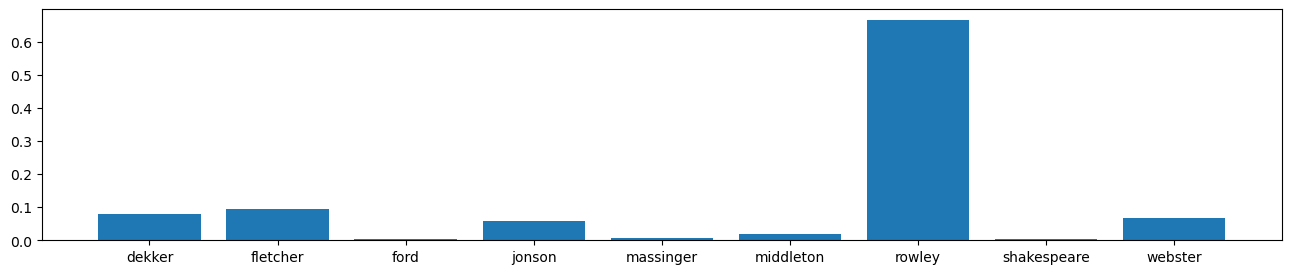

In [7]:
# PLOT CLASSIFICATION LOGITS

import torch.nn.functional as F
import matplotlib.pyplot as plt

x = np.array(authors)
y = np.array(F.softmax(logits).detach().numpy()[0])

plt.figure(figsize=(16, 3))
plt.bar(x,y)
plt.show()

In [8]:
a = outputs.attentions

In [9]:
print(len(a), a[0].shape)
out = np.stack([head.detach().numpy() for head in a], axis=0).squeeze(1)

nested_list = out.tolist()
json_data = json.dumps(nested_list)
with open("./attention_data.json", "w") as f:
    f.write(json_data)

12 torch.Size([1, 12, 128, 128])
